# Philips MRI sprial reconstruction problem

In this notebook I'll explain the problem I encounter with the reconstruction.

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import sigpy as sp
import sigpy.mri as spmri
import sigpy.plot as pl
from PIL import Image
plt.rcParams["animation.html"] = "jshtml"

## Generate spiral coordinates
The following block calculates a single spiral based on machine parameters.

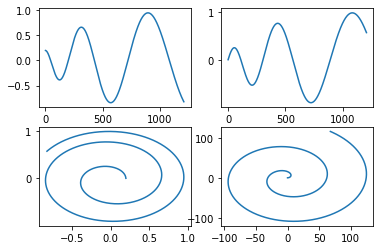

In [7]:
def spiral(t, t_begin, A, omega, lambda_1):
    """
    function to calculate the spiral gradient waveforms
    """
    PI = 3.141593
    UGN1_ACQ_gamma = 42.576 * 1000
    MGG_MSEC = 0.001

    amp = A / (2.0 * PI * UGN1_ACQ_gamma * MGG_MSEC)
    act_t = t
    omega_t = omega * act_t
    lambda_t1 = lambda_1 * act_t + 1.0
    root = np.sqrt(lambda_t1)
    f1 = (omega / root) * (0.5 + 0.5 / lambda_t1)
    f2 = f1 / root
    cosine = np.cos(omega_t / root)
    sine = np.sin(omega_t / root)
    g_x = (amp * (f1 * cosine - f2 * omega_t * sine))
    g_y = (amp * (f1 * sine + f2 * omega_t * cosine))

    return g_x, g_y

"""
Calculate spiral based on machine parameters
"""
# calculate spiral gradient - input parameter following
# Ta = ACQ spiral sampling window
Ta = 5.0
AQ = Ta  # lazy coding
# FOV in mm
FOV = 208
# pixel = spatial resolution in mm
pixel = 1.0
# number of spiral interleaves
interleaves = 48
# spiral variable frequency scale - CSC parameter
CSC_spiral_var_freq_scale = 3.0
# unit conversion factor
MGG_MM = 0.001
# time basis of the gradients in ms
# if this should fit the sampling the sampling tau should be given in ms
sampling_tau = 0.00413223

matrix = FOV / pixel

PI = 3.141593
# %% -------------------------------------------------------------*/
## calculate initial spiral timing             */
##--------------------------------------------------------------*/

spiral_turns = 1.0 * matrix / (2. * interleaves)
A = pixel / (2.0 * FOV * MGG_MM * spiral_turns)
lambda_1 = spiral_turns
if lambda_1 > CSC_spiral_var_freq_scale:
    lambda_1 = CSC_spiral_var_freq_scale

lambda_1 = lambda_1 / Ta
omega = 2 * PI * spiral_turns * np.sqrt(lambda_1 * Ta + 1.0) / Ta
nx = int(Ta / sampling_tau)
gx = np.zeros([nx])
gy = np.zeros([nx])
t = np.arange(nx)

amp = 0
for i in range(nx):

    Ta_begin = 0.0
    Ta = i * sampling_tau
    g_x, g_y = spiral(Ta, Ta_begin, A, omega, lambda_1)

    gx[i] = g_x
    gy[i] = g_y

    a = g_x * g_x + g_y * g_y
    if a > amp:
        amp = a

amp = 1.0 / np.sqrt(amp)
for i in range(nx):
    gx[i] = amp * gx[i]
    gy[i] = amp * gy[i]

fig, axs = plt.subplots(2, 2, num="gradient_plot")
axs[0, 0].plot(t, gx)
axs[0, 1].plot(t, gy)
axs[1, 0].plot(gx, gy)

# integrate over time ==> k(t)
kx = np.zeros([nx])
ky = np.zeros([nx])

for i in range(1, nx):
    kx[i] = kx[i - 1] + gx[i]
    ky[i] = ky[i - 1] + gy[i]
axs[1, 1].plot(kx, ky)
plt.show()

The following block rotates the spiral in 48 steps

In [8]:
%%capture
def rotatespiral(coord, index, max_index=48):
    angle = 2 * np.pi / max_index
    comp_coord = (coord[:, 0] + 1j * coord[:, 1]) * np.exp(1j * angle * (index))
    realcoord = np.real(comp_coord)
    imgcoord = np.imag(comp_coord)
    return np.stack((realcoord, imgcoord), axis=1)

coord = np.zeros((48, 1210, 2))
spiral_coord = np.array((kx,ky)).T
for i in range(coord.shape[0]):
    coord[i, ...] = rotatespiral(spiral_coord, i)

# make into animation
fig, ax = plt.subplots()
h = ax.axis([np.min(coord[:, :, 0]),np.max(coord[:, :, 0]),np.min(coord[:, :, 1]),np.max(coord[:, :, 1])])
l, = ax.plot([],[])

def animate(i):
    l.set_data(coord[i,:,0], coord[i,:,1])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=coord.shape[0])

In [9]:
# Show animation
ani

## Density compensation
Calculate density compensation function based on a paper from hoge

Hoge, R. D., Kwan, R. K. S., & Pike, G. B. (1997). Density compensation functions for spiral MRI. Magnetic Resonance in Medicine, 38(1), 117–128. https://doi.org/10.1002/mrm.1910380117

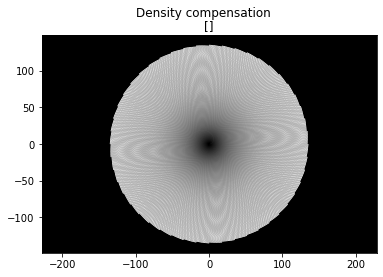

In [10]:
def spiral_dcf(coord):
    dcf = np.zeros((coord.shape[0], coord.shape[1]))
    for i in range(coord.shape[0]):
        deltak = 1000 / 224
        k_mag = np.abs((coord[i, :, 0] ** 2 + coord[i, :, 1] ** 2) ** 0.5) * deltak
        kdiff = np.append([0], np.diff(k_mag))
        dcf[i, :] = k_mag * np.abs(kdiff)
    return dcf
dcf = spiral_dcf(coord)
pl.ScatterPlot(coord, dcf, title='Density compensation')
plt.show()

## Simulate MRI data

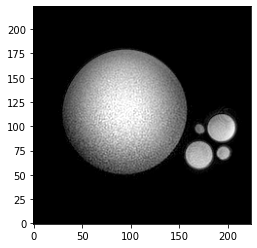

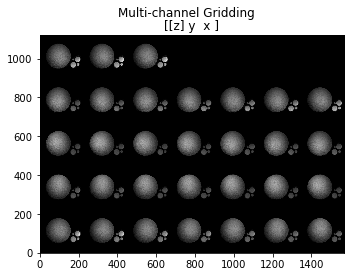

In [15]:
img = np.asarray(Image.open(r'data/fullres.jpg')).astype(np.complex)[np.newaxis, :,:,1]
plt.imshow(np.abs(img[0, ...]), origin='lower', cmap='gray')

#Generate sensitivity maps for 31 coils
maps = spmri.birdcage_maps((31, 224, 224), 0.4/0.244)
imggrid = img*maps

pl.ImagePlot(imggrid, z=0, title='Multi-channel Gridding')
ksp = sp.nufft(imggrid, coord, oversamp=1.0)

## Reconstruct simulated data
The reconstruction algorithm used below is identical to the one used on the sigpy examples shown [here](https://github.com/mikgroup/sigpy-mri-tutorial/blob/master/01-gridding-reconstruction.ipynb).
In that example they use data and radial coordinates from the [ISMRM reproducibility challenge 2019](https://blog.ismrm.org/2019/04/02/ismrm-reproducible-research-study-group-2019-reproduce-a-seminal-paper-initiative/)

ksp shape (31, 48, 1210)


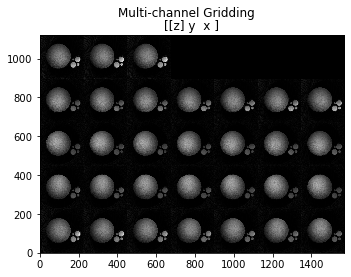

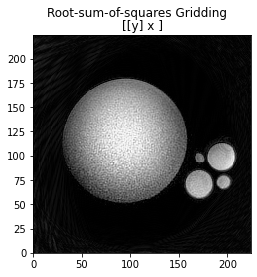

In [16]:
print('ksp shape', end=' ')
print(ksp.shape)
reconimg = sp.nufft_adjoint(ksp * dcf, coord, oshape=imggrid.shape, oversamp=1.0)
pl.ImagePlot(reconimg, z=0, title='Multi-channel Gridding')

img_rss = np.sum(np.abs(reconimg)**2, axis=0)**0.5
pl.ImagePlot(img_rss, title='Root-sum-of-squares Gridding')

## Reconstruct real MRI data

real_ksp shape (31, 48, 1210)


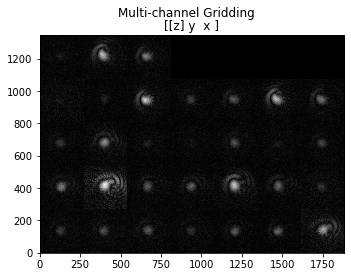

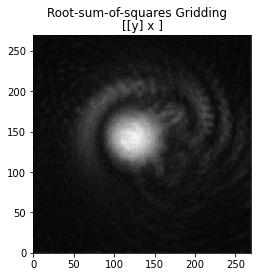

In [17]:
# Load data, to speed up calculation, only the data from the 1st slice is stored in .npy
real_ksp = np.load('data/real_phantom_data.npy')

print('real_ksp shape', end=' ')
print(real_ksp.shape)
img_grid = sp.nufft_adjoint(real_ksp * dcf, coord, oversamp=1.0)
pl.ImagePlot(img_grid, z=0, title='Multi-channel Gridding')

img_rss = np.sum(np.abs(img_grid) ** 2, axis=0) ** 0.5
pl.ImagePlot(img_rss, title='Root-sum-of-squares Gridding')